# Project: A CNN that Removes Lipstick from Images of Women

## Goal: Teach a CNN to Reproduce Images of Caucasian Women while Simultaneously Removing their Lipstick

In this project, I used the [VMU dataset](http://www.antitza.com/makeup-datasets.html) that contains images of caucasian women from the [FRGC dataset](https://www.nist.gov/programs-projects/face-recognition-grand-challenge-frgc) with the corresponding images of the same women with software-generated makeup application. 

The VMU dataset is very limited in size (it only contains 51 subjects), which are not enough to train a convolutional neural network. My solution to this problem was to use a large number of female faces to train a convolutional autoencoder to generally reproduce faces, and then use this trained autoencoder as a starting point and re-train it with pairs of "with makeup" and "without makeup" images (using the VMU dataset). This reduces the need for data since the weights of the autoencoder that reproduces the exact same faces are very similar to the ones that reproduce the same face without lipstick. As shown in the end the network performs really well on the test set. The images appear a little blurry and contain a few off-colored pixels but this should be expected given the large size of the images (150x130 pixels) that include three color channels and the limited size of our training set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import tensorflow as tf

import math

We read data from three datasets. The data from all three datasets was used to train the autoencoder. Only data from the VMU dataset was used for the lipstick removal.

In [2]:
# Read datasets
VMU = loadmat('Makeup_VMU.mat')
YMU = loadmat('Makeup_YMU.mat')
MIW = loadmat('Makeup_MIW.mat')

In [3]:
# reshape all input
def reshape_input(matrix):
    num_img = matrix.shape[1]
    VMU_test = np.reshape(matrix[:,0],(150,130,3),order="F")
    new_matrix = np.zeros((num_img,150,130,3),dtype=np.uint8) # it is important to set it uint8 for imshow to work
    for i in range(num_img):
        new_matrix[i] = np.reshape(matrix[:,i],(150,130,3),order="F")
    return new_matrix
    
X = np.concatenate((reshape_input(VMU['VMU_matrix']), reshape_input(YMU['YMU_matrix']), 
                    reshape_input(MIW['MIW_matrix'])), axis=0)

Total number of images: 1015 of size: (150, 130, 3)


[]

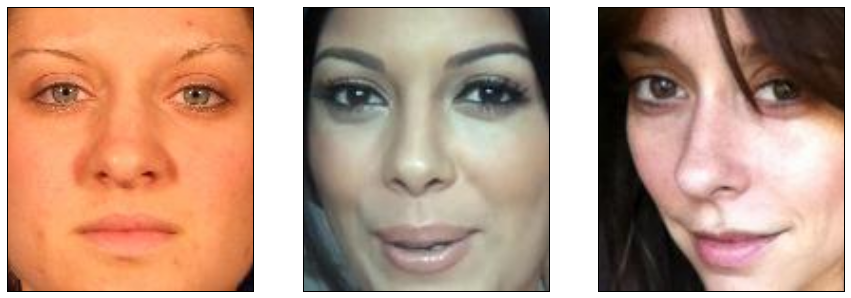

In [4]:
print "Total number of images:", X.shape[0], "of size:", X.shape[1:]
# show first and last image
f, axarr = plt.subplots(1, 3, figsize=(15,40))

axarr[0].imshow(X[0])
axarr[1].imshow(X[500])
axarr[2].imshow(X[-1])
# Hide x and y ticks
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[2].set_xticks([])
axarr[2].set_yticks([])


The total number of images from all three datasets is 1,015. Each image has a size of 150x130 pixels with 3 color channels. The images are already centered and cut. The image on the left is an example from the VMU dataset, the image on the center is from the YMU dataset and the image on the right is from the MIW dataset. The latter dataset contains images of women from different angles. This required a more complex model to train the autoencoder but it made it more generalizable to different potential datasets.

Next, we transformed the pixel values to be between -0.5 and 0.5 to use them as input to our neural network and check if the transformation back to the real values gives the expected result.

In [5]:
# transform pixel values to make them between -0.5 and 0.5
pixel_depth = 255.0  # Number of levels per pixel.
X = (X.astype(float) - pixel_depth / 2) / pixel_depth

[]

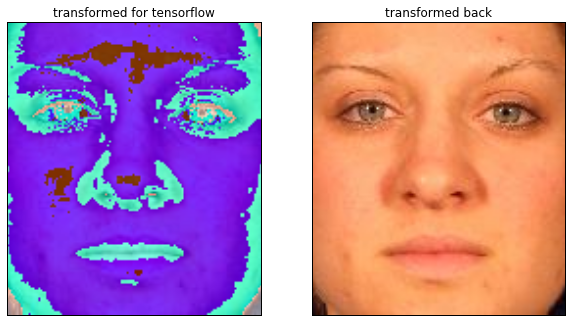

In [6]:
# see if transform them back gives correct result
f, axarr = plt.subplots(1, 2, figsize=(10,40))

axarr[0].imshow(X[0])
axarr[0].set_title('transformed for tensorflow')
axarr[1].imshow((X[0]*pixel_depth + pixel_depth / 2).astype(np.uint8))
axarr[1].set_title('transformed back')
# Hide x and y ticks
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])

Below, we identified the images with the software-generated makeup application and printed the first 10 "with makeup" and "without makeup" pairs. The left column will be used as input dataset and the right column will be used as a label.

In [7]:
# Identify data for which makeup/no-makeup pairs are available
# all files with makeup applications
indices = []
for i,iname in enumerate(VMU['VMU_filenames'][0]):
    if iname[0][-7:] == '_mu.jpg':
        indices += [i]
        
print 'number of images with makeup:',len(indices)

number of images with makeup: 51


(48, 150, 130, 3) (3, 150, 130, 3)


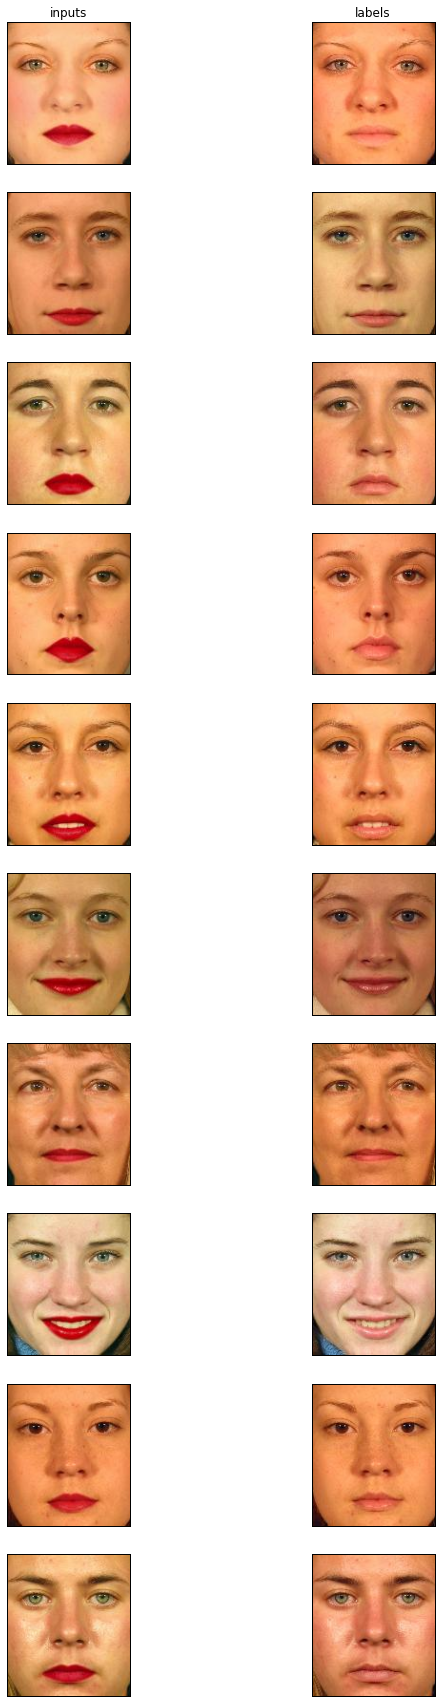

In [8]:
# Create labeled dataset of lipstick (X) and no lipstick (Y)
X_train = X[np.array(indices[:-3])-1]
Y_train = X[np.array(indices[:-3])-3]

X_test = X[np.array(indices[-3:])-1]
Y_test = X[np.array(indices[-3:])-3]

print X_train.shape, X_test.shape

# Image 48 was mislabeled
if X_train.shape[0] > 48:
    Y_train[48] = X[indices[48]+1]
else:
    Y_test[48-X_train.shape[0]] = X[indices[48]+1]

numofimg = 10
f, axarr = plt.subplots(numofimg, 2, figsize=(10,30))
for i in range(numofimg):
    axarr[i,0].imshow((X_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[i,1].imshow((Y_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[0,0].set_title('inputs')
    axarr[0,1].set_title('labels')
    # Hide x and y ticks
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])

As we see in the images above, some pairs have different skin color between the two columns. This is an effect from the software that applied the lipstick on these images. To take better advantage of the autoencoder training, we transformed the results on the right to make the skin color more similar between the two.

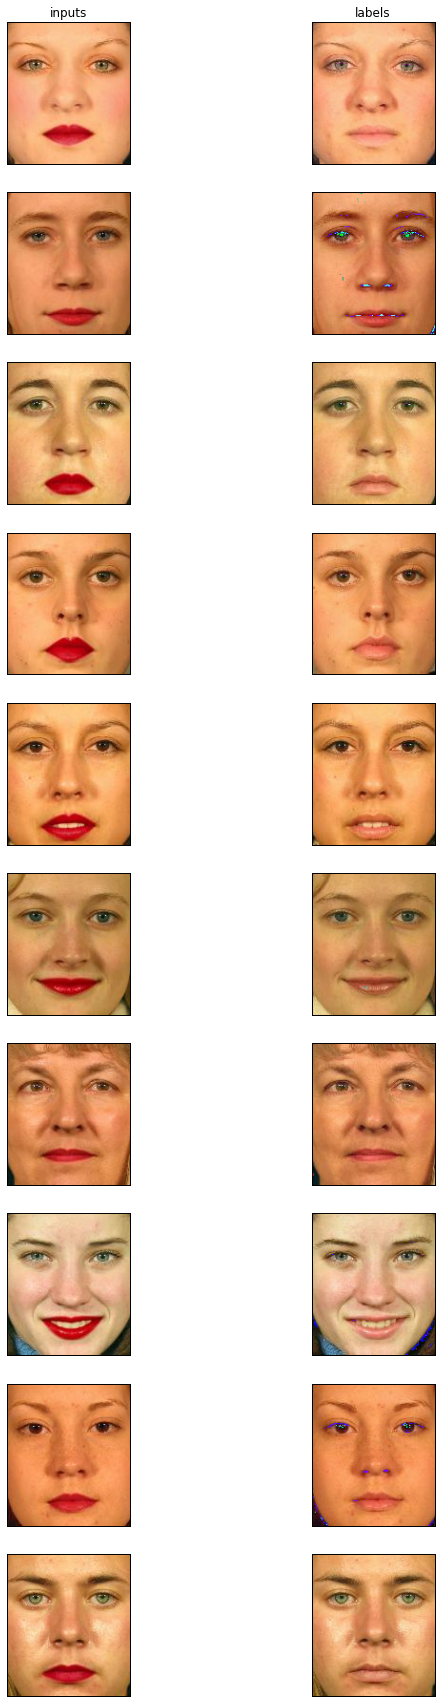

In [9]:
# Adjust color
for i in range(X_train.shape[0]):
    correction = np.mean(X_train[i,75] - Y_train[i,75],axis=0)
    for j in range(3):
        Y_train[i,:,:,j] += correction[j]
    
for i in range(X_test.shape[0]):
    correction = np.mean(X_test[i,75] - Y_test[i,75],axis=0)
    for j in range(3):
        Y_test[i,:,:,j] += correction[j]
    
numofimg = 10
f, axarr = plt.subplots(numofimg, 2, figsize=(10,30))
for i in range(numofimg):
    axarr[i,0].imshow((X_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[i,1].imshow((Y_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[0,0].set_title('inputs')
    axarr[0,1].set_title('labels')
    # Hide x and y ticks
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])

As we see above the skin color is more similar between the two images now. Unfortunately, this transformation created a problem in the color of the pixels of some images (particularly in the eyes and nostrils that have very dark color values). We accepted this imperfection as most images still appear clean and we expect the neural network to average the results of the training set and reduce this error.

Next, we defined the leaky rectifier function and our convolutional autoencoder. The original functions came from a [tensorflow example](https://github.com/pkmital/tensorflow_tutorials/blob/master/python/09_convolutional_autoencoder.py). This network contains 6 convolutional layers and a leaky relu function applied on each layer. 3 of the layers are used for encoding and 3 for decoding.

In [10]:
# From tensorflow libs.activations
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


In [11]:
# Code from tensorflow example of convolutional autoencoder with slight modifications
def autoencoder(input_shape=[None, X.shape[1], X.shape[2], X.shape[3]],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3]):
    """Build a deep denoising autoencoder w/ tied weights.
    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description
    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training
    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    x_label = tf.placeholder(
        tf.float32, input_shape, name='x_label')

    current_input = x

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%f
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_label))

    # %%
    return {'x': x, 'z': z, 'y': y, 'x_label': x_label, 'cost': cost}


We trained our autoencoder (after a little experimentation with the hyperparameters) using 3x3 filters and 120 filters per layer. The first 10 images of the training set after 150 epochs of training are shown below. The third column (target) is irrelevant for this step.

0 452.245
1 296.573
2 231.119
3 191.637
4 166.523
5 150.8
6 131.959
7 120.304
8 109.847
9 101.514
10 95.0777
11 87.172
12 83.5406
13 77.5927
14 71.5243
15 67.9573
16 63.6945
17 64.7585
18 60.8667
19 54.9405
20 65.2521
21 51.2507
22 51.4134
23 47.2195
24 44.7804
25 44.5874
26 43.748
27 42.2991
28 39.7505
29 38.4171
30 38.8153
31 37.4736
32 36.0419
33 36.6228
34 34.2743
35 31.726
36 31.0085
37 30.1722
38 38.4389
39 28.4058
40 32.3009
41 30.9176
42 27.8339
43 29.1158
44 27.1148
45 29.0242
46 29.2518
47 26.7251
48 29.3461
49 24.7884
50 30.8956
51 23.9565
52 23.7849
53 22.2919
54 22.7953
55 25.2675
56 21.1982
57 23.0408
58 28.8162
59 21.3593
60 22.9821
61 23.436
62 20.3697
63 24.0788
64 21.1743
65 20.8407
66 23.5123
67 17.9303
68 21.5901
69 19.4842
70 18.2465
71 20.9787
72 18.5617
73 18.7527
74 16.9587
75 21.2923
76 17.4696
77 17.7217
78 22.5969
79 20.1292
80 16.4515
81 18.5635
82 19.358
83 17.275
84 15.6256
85 16.72
86 15.2451
87 15.7358
88 15.0855
89 15.6469
90 15.5432
91 16.3401
92 14.79

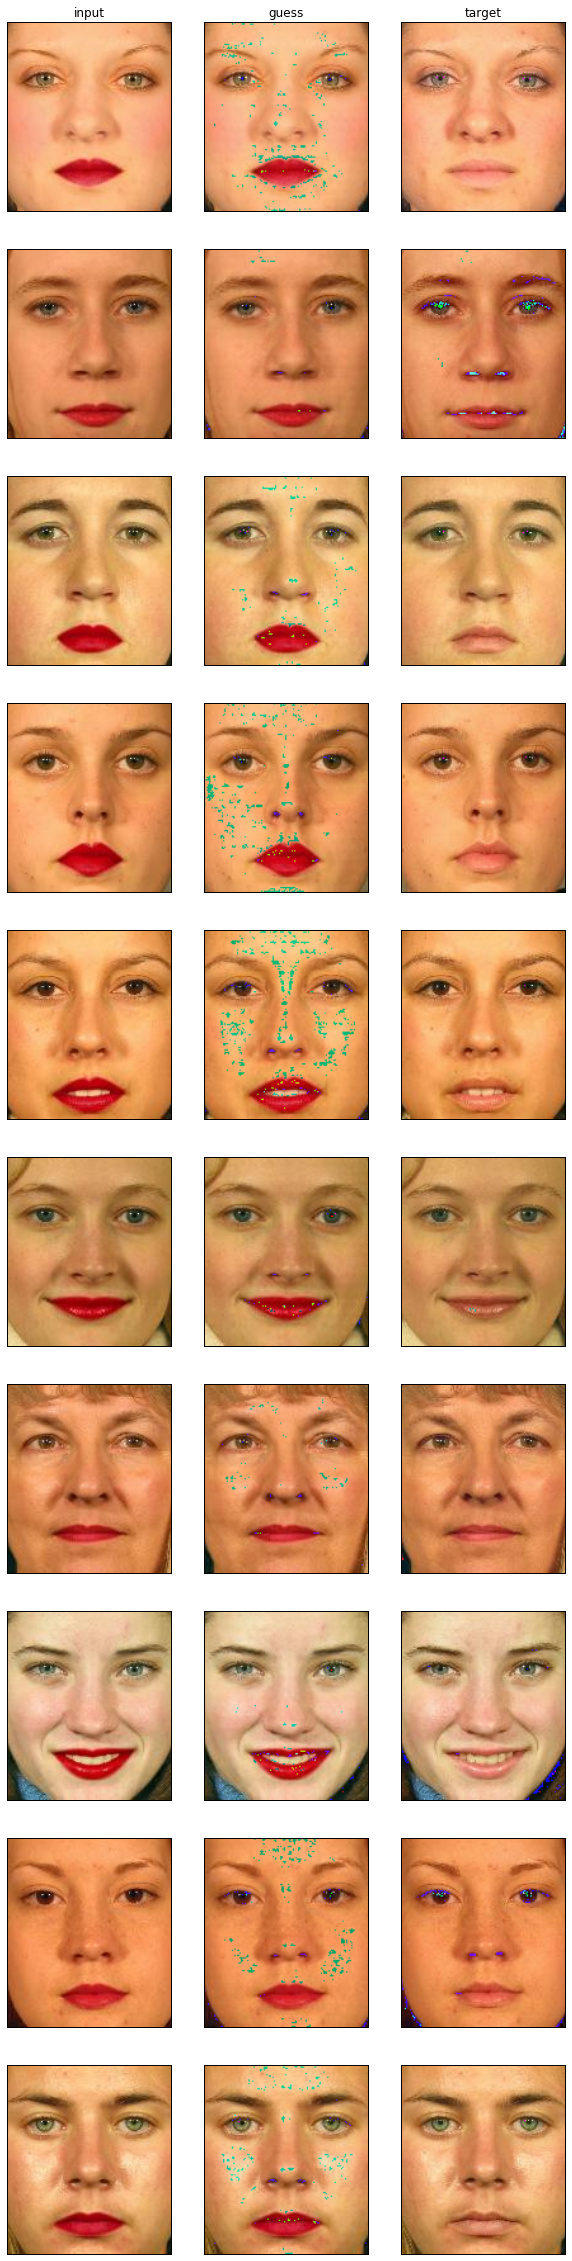

In [12]:
# Fit autoencoder data

ae = autoencoder(n_filters=[1, 120, 120, 120],filter_sizes=[3, 3, 3, 3])

# %%
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])


# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())


# %%
# Fit all training data for autoencoder
batch_size = 2
n_epochs = 150
for epoch_i in range(n_epochs):
    for batch_i in range(X.shape[0] // batch_size):
        batch_xs = X[batch_i*batch_size:batch_i*batch_size + batch_size]
        sess.run(optimizer, feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xs})
    print epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xs})
    

# %%
# Plot example reconstructions
n_examples = 10
test_xs = X_train[:n_examples]
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs})
print recon.shape


f, axarr = plt.subplots(n_examples, 3, figsize=(10,40))
axarr[0,0].set_title('input')
axarr[0,1].set_title('guess')
axarr[0,2].set_title('target')
for example_i in range(n_examples):
    axarr[example_i,0].imshow((X_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,2].imshow((Y_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])
    axarr[example_i,2].set_xticks([])
    axarr[example_i,2].set_yticks([])

As we see above the autoencoder does a good job at reproducing the faces of the left column. The results are shown in the middle column. Most output images contain pixels of apparently-false colors. I believe that this is a consequence of using a very limited dataset for the size of our images and it could be fixed with the use of a more complex model and a larger training set of faces.

Next, we continued training the model defined above by using the "with makeup" and "without makeup" image pairs from the VMU dataset. The training set only contains 48 pairs of images and we trained our network for 50 epochs.

0 513.243
1 463.331
2 395.727
3 415.609
4 345.602
5 320.848
6 314.096
7 308.963
8 303.82
9 300.404
10 297.497
11 294.841
12 292.592
13 290.412
14 288.535
15 286.574
16 284.577
17 282.462
18 280.504
19 278.937
20 277.52
21 275.854
22 274.268
23 272.581
24 271.09
25 270.061
26 268.764
27 267.445
28 266.072
29 264.603
30 263.188
31 262.227
32 260.491
33 258.842
34 257.425
35 255.916
36 254.009
37 252.646
38 250.181
39 248.349
40 245.654
41 243.579
42 242.14
43 240.941
44 239.431
45 238.02
46 236.043
47 234.923
48 234.716
49 232.317
(10, 150, 130, 3)


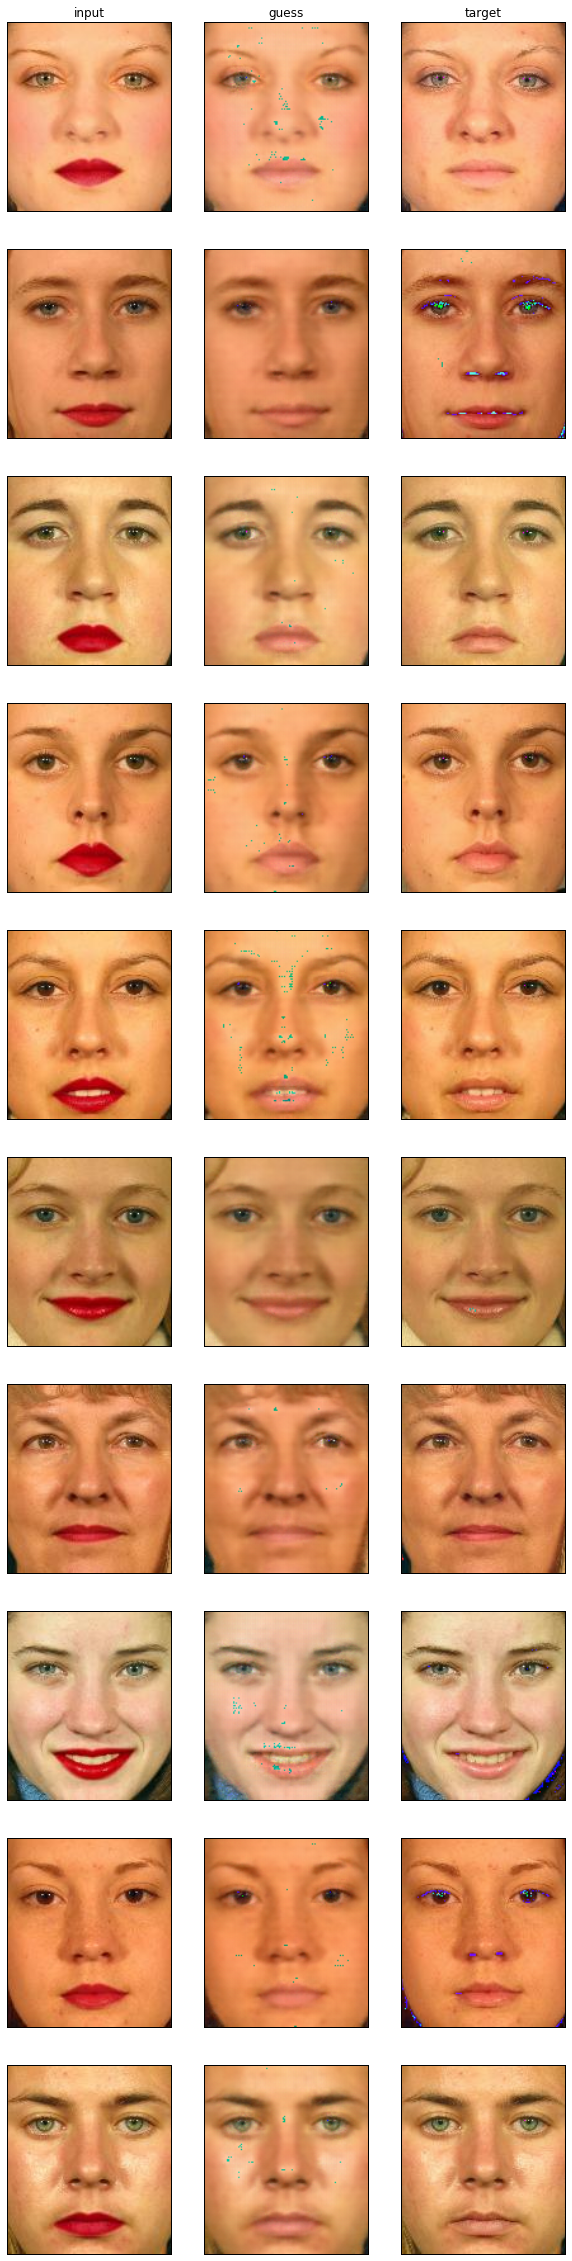

In [13]:
# Fit lipstick data in the same session
n_epochs = 50
for epoch_i in range(n_epochs):
    for batch_i in range(X_train.shape[0] // batch_size):
        batch_xs = X_train[batch_i*batch_size:batch_i*batch_size + batch_size]
        batch_xlabel = Y_train[batch_i*batch_size:batch_i*batch_size + batch_size]
        sess.run(optimizer, feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xlabel})
    print epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xlabel})
    
# %%
# Plot example reconstructions
n_examples = 10
test_xs = X_train[:n_examples]
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs})
print recon.shape


f, axarr = plt.subplots(n_examples, 3, figsize=(10,40))
axarr[0,0].set_title('input')
axarr[0,1].set_title('guess')
axarr[0,2].set_title('target')
for example_i in range(n_examples):
    axarr[example_i,0].imshow((X_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,2].imshow((Y_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])
    axarr[example_i,2].set_xticks([])
    axarr[example_i,2].set_yticks([])

The training set looks good. Even though the output images (middle column) are more blurry than the results of our autoencoder earlier, it seems that the number of off-pixels is also reduced (which is probably a product of averaging). Next, we checked how our model performed on the test set and the results seem similar to the ones above.

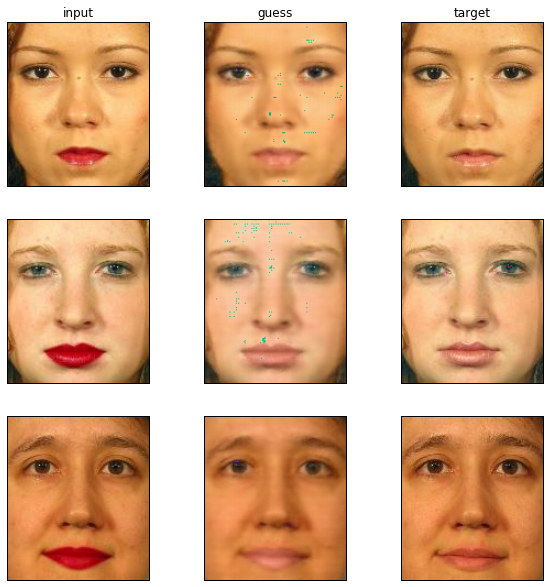

In [16]:
# print test set
recon = sess.run(ae['y'], feed_dict={ae['x']: X_test})

n_examples = X_test.shape[0]

f, axarr = plt.subplots(n_examples, 3, figsize=(10,10))
axarr[0,0].set_title('input')
axarr[0,1].set_title('guess')
axarr[0,2].set_title('target')
for example_i in range(n_examples):
    axarr[example_i,0].imshow((X_test[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,2].imshow((Y_test[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])
    axarr[example_i,2].set_xticks([])
    axarr[example_i,2].set_yticks([])

In [ ]:
# Try on unseen dataset (used for autoencoding)
recon = sess.run(ae['y'], feed_dict={ae['x']: X[-2:]})

f, axarr = plt.subplots(2, 2, figsize=(10,10))

for example_i in range(-2,0):
    axarr[example_i,0].imshow((X[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])

In [84]:
saver = tf.train.Saver()
# Save the variables to disk.
save_path = saver.save(sess, "./model0425.ckpt")
print "Model saved in file: %s" % save_path

Model saved in file: ./model0425.ckpt
